# Hyperparameter tuning

VGG16 image classification model is finetuned using a custom dataset containing 107 classes of images each one corresponding to a yoga pose. The model is submited and deployed in AWS Sagemaker. The code is written in Sagemaker Python SDK.

The Sagemaker ML framework used is PyTorch {`sagemaker.pytorch`}. The model definition and the training and inference code are passed in to PyTorch container via Sagemaker script mode.

SageMaker APIs used: Sagemaker trainning APIs HyperparameterTuner {`sagemaker.tuner.HyperparameterTuner`} and Parameters to perform hyperparameter tuning.

This notebook represents the *submission script* and contains code to download and preprocess the data as well as the setups to Sagemaker APIs to submit and evaluate the training job (i.e. to train and deploy the model).

The *training scrip*, i.e. `hpo.py`, contains the model definition, the training and validation code, and the code to save the model to S3 (`torch.save(model.state_dict(), "model_dir/model.pth")`). Hyperparameters and environmental variables are specified through parser arguments while the *submission script* reads hyperparameters and environmental variables through command line arguments (i.e. at runtime).


## <a name="0">Notebook content:</a>
1. <a href="#1">Notebook set-up</a>
2. <a href="#2">Dataset</a><br>
    2.1. <a href="#2.1">AWS S3 configuration</a><br>
    2.2. <a href="#2.2">ETL</a><br>
    2.3. <a href="#2.3">Manifest files</a><br>
    2.4 <a href="#2.4">Define Data Channels</a>
3. <a href="#3">Hyperparameter Tuning</a><br>
    3.1. <a href="#3.1">Define Pytorch estimator</a><br>
    3.2. <a href="#3.2">Define objective metric and hyperparameters ranges for HyperparameterTuner</a><br>
    3.3. <a href="#3.3">Launch an Hyperparameter Tuning Job</a><br>
    3.4. <a href="#3.4">Run a Warm Start Hyperparameter Tuning</a><br>
    3.5. <a href="#3.5">Launch a second Hyperparameter Tuning Job</a><br>
    3.6. <a href="#3.6">Run a second Warm Start Hyperparameter Tuning</a>
4. <a href="#4">Clean up</a><br>


## 1. <a name="1">Notebook set-up</a>
(<a href="#0">Go to top</a>)

In [1]:
# Import any packages that might be needed
# For instance Boto3 and Sagemaker and PyTorch ML framework 
import boto3
import sagemaker

from sagemaker import get_execution_role

from sagemaker.pytorch import PyTorch

from sagemaker.tuner import(
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import requests
import shutil

import io
import pickle
import json
import random

## 2. <a name="2">Dataset</a>
(<a href="#0">Go to top</a>)

The dataset used is composed of a total of 5994 images of yoga poses. It is a modification of kaggle dataset [yoga-pose-image-classification-dataset](https://www.kaggle.com/datasets/shrutisaxena/yoga-pose-image-classification-dataset?select=dataset) and can be downloaded at [rgb-only-yoga-pose-dataset](https://www.kaggle.com/datasets/franciscadossantos/rgb-only-yoga-pose-dataset).
The dataset contains 107 classes of yoga poses, such as 'adho mukha svanasana', chakravakasana, savasana, etc.
For the scope of this project the dataset was divided into 3 subsets: train, test and validation. There are 3553 images in the training dataset, 1284 images in the test dataset and 1157 images in the validation dataset. For more information on dataset see notebook [convert_image_mode2rgb.ipynb](./convert_image_mode2rgb.ipynb) and support material bellow.


**Support material:**

1. kaggle. [Yoga Pose Image classification dataset](https://www.kaggle.com/datasets/shrutisaxena/yoga-pose-image-classification-dataset?select=dataset)
2. kaggle. [RGB-only Yoga Pose Dataset](https://www.kaggle.com/datasets/franciscadossantos/rgb-only-yoga-pose-dataset)


### 2.1. <a name="2.1">AWS S3 configuration</a>
(<a href="#0">Go to top</a>)

In [2]:
# grab sagemaker session and define s3 bucket name or use sagemaker.Session().default_bucket
# then, define file path prefix to send data to S3 bucket

sm_session = sagemaker.Session()
bucket = "capstone-project-udc2022"  ##aws private account
#bucket = "capstone-project-sett22" ##aws udacity's platform

prefix = "yoga-data"

print(f"Bucket: {bucket}")
print(f"S3 path: {bucket}/{prefix}")

input_data = f"S3 path: {bucket}/{prefix}"

Bucket: capstone-project-udc2022
S3 path: capstone-project-udc2022/yoga-data


### 2.2. <a name="2.2">ETL</a>
(<a href="#0">Go to top</a>)

#### 2.2.1. <a name="2.2.1">kaggle setup</a>

**Note:** first of all download `kaggle.json` from kaggle website and upload it to local directory

In [7]:
# pip install kaggle CLI
!pip install -q kaggle

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

kaggle.json


In [10]:
!chmod 600 ~/.kaggle/kaggle.json  # ensure that other users do not have read access to your credentials

#### 2.2.2. <a name="2.2.2">Fetching the dataset from kaggle</a>

In [12]:
%%time

# download the dataset of interest (using kaggle CLI)

# original dataset
##!kaggle datasets download -d shrutisaxena/yoga-pose-image-classification-dataset

# actual dataset (only images in rgb mode)
!kaggle datasets download -d franciscadossantos/rgb-only-yoga-pose-dataset

 75%|██████████████████████████████▏         | 78.0M/103M [00:00<00:00, 190MB/s]
100%|█████████████████████████████████████████| 103M/103M [00:00<00:00, 200MB/s]
CPU times: user 28.9 ms, sys: 4.83 ms, total: 33.7 ms
Wall time: 1.34 s


In [13]:
# check the data was downloaded
!ls ./

fp_submission_script-1003.ipynb  kaggle.json  remove-nonempty-directories.ipynb
hpo.py				 lost+found   rgb-only-yoga-pose-dataset.zip


In [14]:
%%time

# extract / unzip data with {shutil}
shutil.unpack_archive('./rgb-only-yoga-pose-dataset.zip', './yoga_data/dataset')

"""
# OR
# unzip data using aws CLI
!unzip -d yoga_data rgb-only-yoga-pose-dataset.zip
"""

CPU times: user 956 ms, sys: 159 ms, total: 1.12 s
Wall time: 1.28 s


'\n# OR\n# unzip data using aws CLI\n!unzip -d yoga_data yoga-pose-image-classification-dataset.zip\n'

In [15]:
# take a sneaky peek at the data structure

!ls ./yoga_data/dataset

adho mukha svanasana	     padmasana
adho mukha vriksasana	     parighasana
agnistambhasana		     paripurna navasana
ananda balasana		     parivrtta janu sirsasana
anantasana		     parivrtta parsvakonasana
anjaneyasana		     parivrtta trikonasana
ardha bhekasana		     parsva bakasana
ardha chandrasana	     parsvottanasana
ardha matsyendrasana	     pasasana
ardha pincha mayurasana      paschimottanasana
ardha uttanasana	     phalakasana
ashtanga namaskara	     pincha mayurasana
astavakrasana		     prasarita padottanasana
baddha konasana		     purvottanasana
bakasana		     salabhasana
balasana		     salamba bhujangasana
bhairavasana		     salamba sarvangasana
bharadvajasana i	     salamba sirsasana
bhekasana		     savasana
bhujangasana		     setu bandha sarvangasana
bhujapidasana		     simhasana
bitilasana		     sukhasana
camatkarasana		     supta baddha konasana
chakravakasana		     supta matsyendrasana
chaturanga dandasana	     supta padangusthasana
dandasana		     supta virasana
dhanur

#### 2.2.3. <a name="2.2.3">Listing the classes (yoga poses)</a>

In [17]:
# create a dictionary/list of classes (107 classes) that can be used later when selecting image for quering the model
import os

# get the list of all directories within ./yoga_data/dataset
data_path = "./yoga_data/dataset"
cls_list = os.listdir(data_path)
cls_list.sort()

cls_dict = {}
for i, term in enumerate(cls_list, 1):
    cls_dict[i] = term

print(f"Number of Classes: {len(cls_list)}")

Number of Classes: 107


In [18]:
cls_dict

{1: 'adho mukha svanasana',
 2: 'adho mukha vriksasana',
 3: 'agnistambhasana',
 4: 'ananda balasana',
 5: 'anantasana',
 6: 'anjaneyasana',
 7: 'ardha bhekasana',
 8: 'ardha chandrasana',
 9: 'ardha matsyendrasana',
 10: 'ardha pincha mayurasana',
 11: 'ardha uttanasana',
 12: 'ashtanga namaskara',
 13: 'astavakrasana',
 14: 'baddha konasana',
 15: 'bakasana',
 16: 'balasana',
 17: 'bhairavasana',
 18: 'bharadvajasana i',
 19: 'bhekasana',
 20: 'bhujangasana',
 21: 'bhujapidasana',
 22: 'bitilasana',
 23: 'camatkarasana',
 24: 'chakravakasana',
 25: 'chaturanga dandasana',
 26: 'dandasana',
 27: 'dhanurasana',
 28: 'durvasasana',
 29: 'dwi pada viparita dandasana',
 30: 'eka pada koundinyanasana i',
 31: 'eka pada koundinyanasana ii',
 32: 'eka pada rajakapotasana',
 33: 'eka pada rajakapotasana ii',
 34: 'ganda bherundasana',
 35: 'garbha pindasana',
 36: 'garudasana',
 37: 'gomukhasana',
 38: 'halasana',
 39: 'hanumanasana',
 40: 'janu sirsasana',
 41: 'kapotasana',
 42: 'krounchasa

In [19]:
#counting the number of images

dir = data_path
sum = 0

for i, cls in enumerate(cls_list, 1):
    path = os.path.join(dir, cls)
    for (r, d, f) in os.walk(path):
        sum += len(f)
print("Total number of images in the data set: ", sum)

Total number of images in the data set:  5994


#### 2.2.4. <a name="2.2.5">Split data into train, validation and test sets</a>

In [23]:
!pip install split-folders

In [ ]:
# -----------------------------------------------------------------------------------------

In [37]:
## RUN THIS CELL ONLY IF NEEDED (e.g, if you need to run again the code of the next cell bellow)

# delete local copy of data
if os.path.exists("./yoga_data/subsets"):
    shutil.rmtree("./yoga_data/subsets") #remove non-empty directory {shutil}
    #os.rmdir('./yoga_data/subsets') #remove empty directory {os}
else:
    print("No files found in the directory")


In [ ]:
# -----------------------------------------------------------------------------------------

In [24]:
#randomly sample data into train, validation and test sets/directories (0.7, 0.1, 0.2)

import splitfolders

input_folder = data_path

splitfolders.ratio(input_folder, output="./yoga_data/subsets", seed=1337, ratio=(.7, .1, .2), group_prefix=None, move=False)


Copying files: 5994 files [00:00, 7445.87 files/s]


In [25]:
#!ls ./yoga_data/subsets
os.listdir("./yoga_data/subsets")

['val', 'test', 'train']

In [26]:
## count number of images in each dataset

sets_path = "./yoga_data/subsets"

dset_dict = {
    'train' : 0,
    'val' : 0,
    'test' : 0
}
for k in dset_dict.keys():
    path = os.path.join(sets_path, k)
    for (r, d, f) in os.walk(path, topdown=True):
        for file in f:
            dset_dict[k] += 1 

print(dset_dict)

{'train': 4150, 'val': 550, 'test': 1294}


In [27]:
# visualize train, validation and test ratio

data = {}

dir = sets_path

keys = ['train', 'val', 'test']

for k in keys:
    nf_list = []
    for cls in cls_list:
        path = os.path.join(dir, k, cls)
        for (r, d, f) in os.walk(path):
            nf_list.append(len(f))
    data[k] = nf_list
    print(len(nf_list))

df = pd.DataFrame(data)

#print(df): rows for class and columns for dataset
df

107
107
107


,train,val,test
0,48,6,15
1,41,5,13
2,23,3,7
3,41,5,13
4,30,4,9
...,...,...,...
102,42,6,13
103,35,5,10
104,43,6,13
105,35,5,11


<AxesSubplot:>

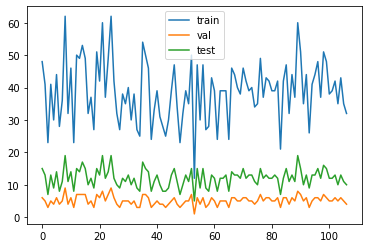

In [28]:
df.plot(kind='line')

#### 2.2.6. <a name="2.2.6">Upload data to AWS S3</a>

In [9]:
%%time

# upload all the data to S3
## upload local 'data' directories (train, test, and val) to S3

# upload data to S3 using aws CLI: aws s3 cp <source> <target> [--options]
!aws s3 cp ./yoga_data/subsets/train s3://{bucket}/{prefix}/train --recursive
!aws s3 cp ./yoga_data/subsets/test s3://{bucket}/{prefix}/test --recursive
!aws s3 cp ./yoga_data/subsets/val s3://{bucket}/{prefix}/val --recursive

"""
## OR upload using sagemaker session
input_data = sm_session.upload_data(path='./yoga_data/subsets', bucket=bucket, key_prefix=prefix)
"""

## print S3 URI
print('path to data in S3: {}'.format(input_data))


upload: yoga_data/subsets/train/adho mukha svanasana/10. screen-shot-2017-09-15-at-17.00.06-1024x585.jpg to s3://capstone-project-udc2022/yoga-data/train/adho mukha svanasana/10. screen-shot-2017-09-15-at-17.00.06-1024x585.jpg
upload: yoga_data/subsets/train/adho mukha svanasana/1. 1.jpg to s3://capstone-project-udc2022/yoga-data/train/adho mukha svanasana/1. 1.jpg
upload: yoga_data/subsets/train/adho mukha svanasana/1. 5-benefits-of-downward-facing-dog-pose.jpg to s3://capstone-project-udc2022/yoga-data/train/adho mukha svanasana/1. 5-benefits-of-downward-facing-dog-pose.jpg
upload: yoga_data/subsets/train/adho mukha svanasana/17. screen_shot_2014-03-20_at_2.05.15_pm.jpg to s3://capstone-project-udc2022/yoga-data/train/adho mukha svanasana/17. screen_shot_2014-03-20_at_2.05.15_pm.jpg
upload: yoga_data/subsets/train/adho mukha svanasana/11. yoga_anatomy_using_muscle_awareness_to_lower_your_heels_in_downward_facing_dog_pose.jpg to s3://capstone-project-udc2022/yoga-data/train/adho mukha

### 2.3. <a name="2.3">Manifest files</a>
(<a href="#0">Go to top</a>)

["A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The image index in the first column must be unique across all of the images. The set of class label indices are numbered successively and the numbering should start with 0. For example, 0 for the cat class, 1 for the dog class, and so on for additional classes."](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) (Sagemaker Developer Guide: Image Classification Algorithm. Train with Image Format)

In [10]:
# Build a list file (.lst file) with the labels for each set of data
# "labels" are classes numbers from from 0 to 106 (107 classes)
## Note, labels start from zero (0) to meet Sagemaker requirements
# "s3_path" are dir/file_name
# "row" are the row indexes [0, num_images-1]

def create_manifest_file(dir, prefix):
    path = os.path.join(dir, prefix)
    dir_list = os.listdir(path)
    dir_list.sort()

    filepath_list = []
    label_list = []
    for i, label in enumerate(dir_list, 0):
        directory = os.path.join(path, label)
        for (r, d, f) in os.walk(directory, topdown=True):
            for file in f:
                filepath_list.append(os.path.join(label, file))
                label_list.append(i) ## [0 to 106]

    pd.DataFrame({
        "row":range(len(filepath_list)),
        "labels":label_list,
        "s3_path":filepath_list
    }).to_csv(path_or_buf=os.path.join(dir, f"{prefix}.lst"), sep='\t', header=False, index=False)
    
    print(f"{prefix}.lst created!")

In [11]:
dir = "./yoga_data/subsets"

create_manifest_file(dir, 'train')
create_manifest_file(dir, 'test')
create_manifest_file(dir, 'val')

train.lst created!
test.lst created!
val.lst created!


In [12]:
!ls ./yoga_data/subsets

test  test.lst	train  train.lst  val  val.lst


In [13]:
%%time
# upload list files to s3

train_lst_path = sm_session.upload_data(path='./yoga_data/subsets/train.lst', bucket=bucket, key_prefix=prefix)
print('train.lst uploaded to the s3 path:\n {}'.format(train_lst_path))

test_lst_path = sm_session.upload_data(path='./yoga_data/subsets/test.lst', bucket=bucket, key_prefix=prefix)
print('test.lst uploaded to the s3 path:\n {}'.format(test_lst_path))

valid_lst_path = sm_session.upload_data(path='./yoga_data/subsets/val.lst', bucket=bucket, key_prefix=prefix)
print('valid.lst uploaded to the s3 path:\n {}'.format(valid_lst_path))

train.lst uploaded to the s3 path:
 s3://capstone-project-udc2022/yoga-data/train.lst
test.lst uploaded to the s3 path:
 s3://capstone-project-udc2022/yoga-data/test.lst
valid.lst uploaded to the s3 path:
 s3://capstone-project-udc2022/yoga-data/val.lst
CPU times: user 72.3 ms, sys: 9.13 ms, total: 81.4 ms
Wall time: 510 ms


In [ ]:
# -----------------------------------------------------------------------------------------

In [3]:
## RUN THIS CELL ONLY IF NEEDED
## e.g., in case you didn't run the cell above and/or you need to re-define the paths to metadata (s3 paths to .lst files)

input_data = f"s3://{bucket}/{prefix}"

train_lst_path = f"s3://{bucket}/{prefix}/train.lst"

test_lst_path = f"s3://{bucket}/{prefix}/test.lst"

valid_lst_path = f"s3://{bucket}/{prefix}/val.lst"


In [ ]:
# -----------------------------------------------------------------------------------------

In [4]:
print('Bucket:\n {}'.format(bucket))

print('s3 path to data:\n {}'.format(input_data))

print('s3 path to train.lst:\n {}'.format(train_lst_path))

print('s3 path to test.lst:\n {}'.format(test_lst_path))

print('s3 path to valid.lst:\n {}'.format(valid_lst_path))

Bucket:
 capstone-project-udc2022
s3 path to data:
 s3://capstone-project-udc2022/yoga-data
s3 path to train.lst:
 s3://capstone-project-udc2022/yoga-data/train.lst
s3 path to test.lst:
 s3://capstone-project-udc2022/yoga-data/test.lst
s3 path to valid.lst:
 s3://capstone-project-udc2022/yoga-data/val.lst


### 2.4 <a name="2.4">Define Data Channels</a>
(<a href="#0">Go to top</a>)


In [5]:
# model data channels

model_inputs = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data="s3://capstone-project-udc2022/yoga-data/train/",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "test": sagemaker.inputs.TrainingInput(
        s3_data="s3://capstone-project-udc2022/yoga-data/test/",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "valid": sagemaker.inputs.TrainingInput(
        s3_data="s3://capstone-project-udc2022/yoga-data/val/",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "train_lst": sagemaker.inputs.TrainingInput(
        s3_data=train_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "test_lst": sagemaker.inputs.TrainingInput(
        s3_data=test_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "valid_lst": sagemaker.inputs.TrainingInput(
        s3_data=valid_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    )
}


## 3. <a name="3">Hyperparameter Tuning</a>
(<a href="#0">Go to top</a>)


### 3.1. <a name="3.1">Define Pytorch estimator</a>
(<a href="#0">Go to top</a>)

**Recommeded reading:**

1. AWS Sagemaker Read the Docs. Use PyTorch with the SageMaker Python SDK: [Deploy PyTorch Models](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html)

2. Amazon Sagemaker developer guide: [Image Classification Instances](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html#IC-instances)

3. AWS Sagemaker: [SageMaker instance pricing](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html)


In [8]:
# define values for hyperparameters
hyperparameters = {
    'epochs':'5',
    'batch_size':'20',
    'test_batch_size':'16',
    'lr':'0.1'
}

# initialize estimators
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="capstone-project", #prefix for training job name
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36"
)

In [ ]:
%%time
### test model fitting :::--->

estimator.fit(inputs=model_inputs, logs=True)

2022-09-30 14:02:29 Starting - Starting the training job...
2022-09-30 14:02:53 Starting - Preparing the instances for trainingProfilerReport-1664546548: InProgress
......
2022-09-30 14:03:53 Downloading - Downloading input data......
2022-09-30 14:04:54 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-30 14:05:04,220 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-30 14:05:04,223 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-30 14:05:04,231 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-30 14:05:04,238 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-30 14:05:04,632 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-30 14:05:04,646 sagemaker-training-tool

### 3.2. <a name="3.2">Define objective metric and hyperparameters ranges for HyperparameterTuner</a>
(<a href="#0">Go to top</a>)

["The SageMaker Python SDK allows you to specify a name and a regular expression for metrics you want to track for training. A regular expression (regex) matches what is in the training algorithm logs, like a search function."](https://sagemaker.readthedocs.io/en/stable/overview.html#training-metrics) (Sagemaker Read the Docs: Using the SageMaker Python SDK. Using Estimators. Training Metrics)

See also:
1. Sagemaker Developer Guide: [Define Metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-metrics.html)

In [14]:
sm_client = boto3.Session().client("sagemaker")

In [6]:
# define hyperparameters ranges
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.005, 0.015, scaling_type='Logarithmic'),
    'batch_size': CategoricalParameter([16, 20, 30, 40]),
    'test_batch_size': CategoricalParameter([10, 16, 20]),
    'epochs': CategoricalParameter([5, 10])
}

# objective metric to be used (added to HyperparameterTuner bellow)
objective_metric_name = "average test loss"

# define whether the metric needs to be minimized or maximized
objective_type = "Minimize"

# tell sagemaker what to look for in the logs (define training metrics)
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


### 3.3. <a name="3.3">Launch an Hyperparameter Tuning Job</a>
(<a href="#0">Go to top</a>)


In [23]:
# create hyperparameter tuner object and pass in the estimator
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=6, # number of hyperparameter jobs
    max_parallel_jobs=1,
    base_tuning_job_name=prefix,
)

In [ ]:
%%time
tuner.fit(inputs=model_inputs, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [19]:
tuning_job_name = 'yoga-data-221001-1053'

In [17]:
tuner_df = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe().sort_values(
    ["FinalObjectiveValue"], ascending=True
)

tuner_df

,batch_size,epochs,lr,test_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""16""","""10""",0.015000,"""20""",yoga-data-221001-1053-006-977a3a98,Completed,0.195545,2022-10-01 14:26:03+00:00,2022-10-01 15:25:04+00:00,3541.0
5,"""30""","""10""",0.006869,"""20""",yoga-data-221001-1053-001-1ea1055c,Completed,0.214853,2022-10-01 10:54:40+00:00,2022-10-01 11:49:29+00:00,3289.0
2,"""20""","""10""",0.009764,"""16""",yoga-data-221001-1053-004-3027d64b,Completed,0.256991,2022-10-01 12:51:25+00:00,2022-10-01 13:49:06+00:00,3461.0
3,"""40""","""5""",0.005823,"""16""",yoga-data-221001-1053-003-6453519c,Completed,0.284018,2022-10-01 12:22:21+00:00,2022-10-01 12:51:04+00:00,1723.0
1,"""20""","""5""",0.006784,"""10""",yoga-data-221001-1053-005-8844d49b,Completed,0.449771,2022-10-01 13:51:10+00:00,2022-10-01 14:23:19+00:00,1929.0
4,"""40""","""5""",0.007682,"""10""",yoga-data-221001-1053-002-4f165926,Completed,0.449968,2022-10-01 11:53:15+00:00,2022-10-01 12:21:58+00:00,1723.0


In [20]:
best_training_job = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName = tuning_job_name
)["BestTrainingJob"]

best_training_job

{'TrainingJobName': 'yoga-data-221001-1053-006-977a3a98',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:967161726274:training-job/yoga-data-221001-1053-006-977a3a98',
 'CreationTime': datetime.datetime(2022, 10, 1, 14, 25, 57, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2022, 10, 1, 14, 26, 3, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2022, 10, 1, 15, 25, 4, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'batch_size': '"16"',
  'epochs': '"10"',
  'lr': '0.014999999999999998',
  'test_batch_size': '"20"'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'average test loss',
  'Value': 0.1955445408821106},
 'ObjectiveStatus': 'Succeeded'}

In [18]:
#Get the hyperparameters of the best trained model
best_estimator_hyperparameters = best_training_job['TunedHyperParameters']

print(f"epochs: {best_estimator_hyperparameters['epochs']}")

print(f"Test batch_size: {best_estimator_hyperparameters['test_batch_size']}")

print(f"Best batch_size: {best_estimator_hyperparameters['batch_size']}")

print(f"Best lr: {best_estimator_hyperparameters['lr']}")

epochs: "10"
Test batch_size: "20"
Best batch_size: "16"
Best lr: 0.014999999999999998


In [ ]:
"""
epochs = 10
Test batch_size = 20
Best batch_size = 16
Best lr = 0.014999999999999998
"""

### 3.4. <a name="3.4">Run a Warm Start Hyperparameter Tuning</a>
(<a href="#0">Go to top</a>)

**References:**

1. Amazon SageMaker Developer Guider. [Run a Warm Start Hyperparameter Tuning Job](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-warm-start.html)

2. GitHub. aws / amazon-sagemaker-examples. [Automatic Model Tuning : Warm Starting Tuning Jobs](https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/image_classification_warmstart/hpo_image_classification_warmstart.ipynb)

In [21]:
from sagemaker.tuner import WarmStartConfig, WarmStartTypes

parent_tuning_job_name = tuning_job_name
warm_start_config = WarmStartConfig(
    WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, parents={parent_tuning_job_name}
)

parent_tuning_job_name

'yoga-data-221001-1053'

In [24]:
# create warm start hyperparameter tuner object (pass in the estimator and parent tunning - warm_start_config)
warmstart_tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=6, # number of hyperparameter jobs
    max_parallel_jobs=1,
    base_tuning_job_name=f"{prefix}-warmstart",
    warm_start_config=warm_start_config,
)


In [ ]:
warmstart_tuner.fit(inputs=model_inputs, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
warmstart_tuner_job_name = 'yoga-data-warmstart-221003-0705'

In [6]:
warmstart_df = sagemaker.HyperparameterTuningJobAnalytics(warmstart_tuner_job_name).dataframe().sort_values(
    ["FinalObjectiveValue"], ascending=True
)

warmstart_df

,batch_size,epochs,lr,test_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""16""","""10""",0.015000,"""20""",yoga-data-warmstart-221003-0705-006-1efd342b,Completed,0.195014,2022-10-03 11:24:31+00:00,2022-10-03 12:24:32+00:00,3601.0
5,"""30""","""5""",0.009932,"""20""",yoga-data-warmstart-221003-0705-001-1426c381,Completed,0.220627,2022-10-03 07:06:36+00:00,2022-10-03 07:36:45+00:00,1809.0
3,"""16""","""10""",0.011565,"""10""",yoga-data-warmstart-221003-0705-003-dd5cf26e,Completed,0.401997,2022-10-03 08:15:06+00:00,2022-10-03 09:15:17+00:00,3611.0
2,"""40""","""10""",0.005663,"""10""",yoga-data-warmstart-221003-0705-004-6b11f9f7,Completed,0.440784,2022-10-03 09:24:50+00:00,2022-10-03 10:19:22+00:00,3272.0
1,"""40""","""10""",0.005105,"""10""",yoga-data-warmstart-221003-0705-005-a7434cd7,Completed,0.442340,2022-10-03 10:24:36+00:00,2022-10-03 11:18:41+00:00,3245.0
4,"""30""","""5""",0.006317,"""10""",yoga-data-warmstart-221003-0705-002-c110c11f,Completed,0.449626,2022-10-03 07:40:21+00:00,2022-10-03 08:09:50+00:00,1769.0


In [8]:
best_training_job = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName = warmstart_tuner_job_name
)["BestTrainingJob"]

best_training_job

{'TrainingJobName': 'yoga-data-warmstart-221003-0705-006-1efd342b',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:967161726274:training-job/yoga-data-warmstart-221003-0705-006-1efd342b',
 'CreationTime': datetime.datetime(2022, 10, 3, 11, 24, 26, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2022, 10, 3, 11, 24, 31, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2022, 10, 3, 12, 24, 32, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'batch_size': '"16"',
  'epochs': '"10"',
  'lr': '0.014999999999999998',
  'test_batch_size': '"20"'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'average test loss',
  'Value': 0.19501371681690216},
 'ObjectiveStatus': 'Succeeded'}

### 3.5. <a name="3.5">Launch a second Hyperparameter Tuning Job (to narrow the hyperparameters values)</a>
(<a href="#0">Go to top</a>)


In [46]:
# define hyperparameters ranges
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.015, 0.125, scaling_type='Logarithmic'),
    'batch_size': CategoricalParameter([16, 20, 30]),
    'test_batch_size': CategoricalParameter([16, 20])
}
## epochs = 6 #default value

# objective metric to be used (added to HyperparameterTuner bellow)
objective_metric_name = "average test loss"

# define whether the metric needs to be minimized or maximized
objective_type = "Minimize"

# tell sagemaker what to look for in the logs (define training metrics)
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


In [47]:
# create hyperparameter tuner object and pass in the estimator
sc_tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=10, # number of hyperparameter jobs
    max_parallel_jobs=1,
    base_tuning_job_name=prefix,
)

In [ ]:
%%time
sc_tuner.fit(inputs=model_inputs, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [49]:
# fetch name of best training job
sc_tuner_job_name = sc_tuner._current_job_name
sc_tuner_best_training_job = sc_tuner.best_training_job()

print(f"Tuner name: {sc_tuner_job_name} \nBest training job: {sc_tuner_best_training_job}")

Tuner name: yoga-data-221004-1441 
Best training job: yoga-data-221004-1441-010-b8df99a3


In [51]:
# Grab the hyperparameters of the best model
best_estimator_hyperparameters = sc_tuner.best_estimator().hyperparameters()

print("Best hyperparameters: {}".format(best_estimator_hyperparameters))


2022-10-04 20:19:00 Starting - Found matching resource for reuse
2022-10-04 20:19:00 Downloading - Downloading input data
2022-10-04 20:19:00 Training - Training image download completed. Training in progress.
2022-10-04 20:19:00 Uploading - Uploading generated training model
2022-10-04 20:19:00 Completed - Resource retained for reuse
Best hyperparameters: {'_tuning_objective_metric': '"average test loss"', 'batch_size': '"30"', 'epochs': '"5"', 'lr': '0.12162268771304077', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"sagemaker-project3-2022-10-04-14-41-10-078"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-543585564521/sagemaker-project3-2022-10-04-14-41-10-078/source/sourcedir.tar.gz"', 'test_batch_size': '"20"'}


In [52]:
results = sc_tuner.analytics()
results_df = results.dataframe()

results_df

,batch_size,lr,test_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""30""",0.121623,"""20""",yoga-data-221004-1441-010-b8df99a3,Completed,0.162172,2022-10-04 19:49:49+00:00,2022-10-04 20:18:58+00:00,1749.0
1,"""16""",0.120279,"""20""",yoga-data-221004-1441-009-67309d49,Completed,0.174920,2022-10-04 19:15:14+00:00,2022-10-04 19:47:19+00:00,1925.0
2,"""20""",0.125000,"""20""",yoga-data-221004-1441-008-c92f51c6,Completed,0.167450,2022-10-04 18:40:18+00:00,2022-10-04 19:10:47+00:00,1829.0
3,"""30""",0.063256,"""20""",yoga-data-221004-1441-007-a2c91766,Completed,0.179574,2022-10-04 18:10:26+00:00,2022-10-04 18:39:40+00:00,1754.0
4,"""16""",0.049801,"""20""",yoga-data-221004-1441-006-31ed847a,Completed,0.187424,2022-10-04 17:35:29+00:00,2022-10-04 18:06:32+00:00,1863.0
5,"""16""",0.099809,"""16""",yoga-data-221004-1441-005-1df231ee,Completed,0.219874,2022-10-04 17:00:40+00:00,2022-10-04 17:32:46+00:00,1926.0
6,"""30""",0.056973,"""16""",yoga-data-221004-1441-004-6901c8c0,Completed,0.228180,2022-10-04 16:25:46+00:00,2022-10-04 16:55:00+00:00,1754.0
7,"""20""",0.017917,"""16""",yoga-data-221004-1441-003-03bb79e8,Completed,0.260718,2022-10-04 15:50:57+00:00,2022-10-04 16:21:11+00:00,1814.0
8,"""20""",0.108763,"""16""",yoga-data-221004-1441-002-2daf2b77,Completed,0.213266,2022-10-04 15:16:09+00:00,2022-10-04 15:46:18+00:00,1809.0
9,"""16""",0.017569,"""20""",yoga-data-221004-1441-001-ddee9d6a,Completed,0.210159,2022-10-04 14:42:24+00:00,2022-10-04 15:14:50+00:00,1946.0


### 3.6. <a name="3.6">Run a second Warm Start Hyperparameter Tuning</a>
(<a href="#0">Go to top</a>)


In [6]:
from sagemaker.tuner import WarmStartConfig, WarmStartTypes

tuning_job_name = "yoga-data-221004-1441"

parent_tuning_job_name = tuning_job_name
warm_start_config = WarmStartConfig(
    WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, parents={parent_tuning_job_name}
)

parent_tuning_job_name

'yoga-data-221004-1441'

In [9]:
# define values for static hyperparameters
hyperparameters = {'epochs':'6', 'test_batch_size':'20'}

# initialize estimators
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="capstone-project",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36"
)

# define hyperparameters ranges for tunning job
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.120, 0.125, scaling_type='Logarithmic'),
    'batch_size': CategoricalParameter([20, 30]),
}

# objective metric to be used (added to HyperparameterTuner bellow)
objective_metric_name = "average test loss"

# define whether the metric needs to be minimized or maximized
objective_type = "Minimize"

# tell sagemaker what to look for in the logs (define training metrics)
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

# create warm start hyperparameter tuner object (pass in the estimator and parent tunning - warm_start_config)
sec_warmstart_tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=6, # number of hyperparameter jobs
    max_parallel_jobs=1,
    base_tuning_job_name=f"{prefix}-sec-warmstart",
    warm_start_config=warm_start_config,
)


In [ ]:
sec_warmstart_tuner.fit(inputs=model_inputs, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [11]:
# fetch name of best training job
sec_warmstart_tuner_job_name = sec_warmstart_tuner._current_job_name
sec_warmstart_tuner_best_training_job = sec_warmstart_tuner.best_training_job()

print(f"Tuner name: {sec_warmstart_tuner_job_name} \nBest training job: {sec_warmstart_tuner_best_training_job}")

Tuner name: yoga-data-sec-warmst-221010-1656 
Best training job: yoga-data-sec-warmst-221010-1656-002-1878c85f


In [12]:
warmstart_df = sagemaker.HyperparameterTuningJobAnalytics(sec_warmstart_tuner_job_name).dataframe().sort_values(
    ["FinalObjectiveValue"], ascending=True
)

warmstart_df

,batch_size,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,"""30""",0.121821,yoga-data-sec-warmst-221010-1656-002-1878c85f,Completed,0.155509,2022-10-10 17:38:12+00:00,2022-10-10 18:12:53+00:00,2081.0
0,"""30""",0.124203,yoga-data-sec-warmst-221010-1656-006-d5eee67b,Completed,0.155564,2022-10-10 20:18:15+00:00,2022-10-10 20:53:18+00:00,2103.0
5,"""30""",0.121777,yoga-data-sec-warmst-221010-1656-001-433b6b1a,Completed,0.155790,2022-10-10 16:58:01+00:00,2022-10-10 17:34:48+00:00,2207.0
3,"""20""",0.120664,yoga-data-sec-warmst-221010-1656-003-75ddfa31,Completed,0.162871,2022-10-10 18:13:03+00:00,2022-10-10 18:49:22+00:00,2179.0
2,"""20""",0.120950,yoga-data-sec-warmst-221010-1656-004-d6a4f16e,Completed,0.163259,2022-10-10 18:54:46+00:00,2022-10-10 19:31:02+00:00,2176.0
1,"""20""",0.120222,yoga-data-sec-warmst-221010-1656-005-38b5ff5c,Completed,0.163851,2022-10-10 19:36:27+00:00,2022-10-10 20:12:43+00:00,2176.0


In [15]:
best_training_job = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName = sec_warmstart_tuner_job_name
)["BestTrainingJob"]

best_training_job['TunedHyperParameters']

{'batch_size': '"30"', 'lr': '0.12182095106235333'}

In [ ]:
"""
epochs = 6
Test batch_size = 20
Best batch_size = 30
Best lr = 0.12182095106235333
"""

### 4. <a name="4">Clean up</a>
(<a href="#0">Go to top</a>)


In [ ]:
# optional: delete local copy of data
if os.path.exists("./yoga_data/dataset"):
    shutil.rmtree("./yoga_data/dataset" #remove non-empty directory {shutil}
    #os.rmdir("./yoga_data/dataset") #remove empty directory
else:
    print("Files does not exist")

In [ ]:
os.remove("./rgb-only-yoga-pose-dataset.zip") # delete original dataset zip file
os.remove("./kaggle.json") # delete file with kaggle credentials